# Operations
In the prior notebook, we showed how to use an `edit.pipeline`, but we just used the default sample pipeline.

This notebook looks to explain and detail how to go about constructing a new pipeline.

In [1]:
import edit.pipeline
import edit.data

The construction of these pipelines can be quite complex, so it is best to take an iterative approach, slowly adding more steps and checking the output to ensure it is what you expect it to be.

edit.pipeline consists of by default the basic blocks to prepare data, and should be enough for most cases. But can be easily extended to add additonal features

All operations that are provided are accessible under `edit.pipeline.operations`. Multiple data types / frameworks are currently implemented,

In [2]:
edit.pipeline.operations?

Type:        module
String form: <module 'edit.pipeline.operations' from '/g/data/eu56/hc7988/Projects/EDIT/pipeline_V2/src/edit/pipeline/operations/__init__.py'>
File:        /g/data/eu56/hc7988/Projects/EDIT/pipeline_V2/src/edit/pipeline/operations/__init__.py
Docstring:  
Pipeline Operations

| SubModules | Info |
| ---------- | ---- |
| numpy | Numpy arrays |
| xarray | Xarray |
| dask   | Dask arrays |
| transform   | Transformations |

Each framework seeks to provide the neccessary operations to prepare data in that type, with conversion available between the three.

Dask and Numpy attempt to be exact mirrors of each other, just implemented in the host framework

In [3]:
example_index = edit.data.archive.ERA5.sample()
example_index

ERA5
	Description                    ECWMF ReAnalysis v5
		 range      '1970-current'                
		 Documentation 'https://confluence.ecmwf.i...


	Initialisation                 
		 level_value None                          
		 product    'reanalysis'                  
		 variables  ['2t']                        
	Transforms                     
		 StandardCoordinateNames {'latitude': "['lat', 'Latitude', 'yt_oce...", 'longitude': "['lon', 'Longitude', 'xt_oc...", 'replacement_dictionary': 'None                          ', 'time': "['Time']                      "}
		 Rename     {'names': {'t2m': "'2t'                          ", 'u10': "'10u'                         ", 'v10': "'10v'                         ", 'siconc': "'ci'                          "}}

So, we now have our index, our view into the data, it will be the first step of our pipeline. 

In [4]:
pipe = edit.pipeline.Pipeline(
    example_index
)
pipe

This is the most basic of pipelines consisting of only a single step.

Just like an `edit.data.Index` it can be indexed to get data from

In [5]:
pipe['2000-01-01T00']

<xarray.Dataset> Size: 8MB
Dimensions:    (longitude: 1440, latitude: 721, time: 1)
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 8B 2000-01-01
Data variables:
    2t         (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 182, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-30 21:47:55 UTC+1000 by era5_replication_tools-1.2....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis 2m_temperature 20000101-20000131

As it is an `xarry` object, if we want to modify it we should use the `xarray` operations

In [6]:
edit.pipeline.operations.xarray?

Type:        module
String form: <module 'edit.pipeline.operations.xarray' from '/g/data/eu56/hc7988/Projects/EDIT/pipeline_V2/src/edit/pipeline/operations/xarray/__init__.py'>
File:        /g/data/eu56/hc7988/Projects/EDIT/pipeline_V2/src/edit/pipeline/operations/xarray/__init__.py
Docstring:  
xarray Operations

| Category | Description | Available |
| -------- | ----------- | --------- |
| Compute  | Call compute on an xarray object | `Compute` |
| Chunk  | Rechunk xarray object | `Chunk` |
| conversion | Convert datasets between numpy or dask arrays | `ToNumpy`, `ToDask` |
| filters | Filter data when iterating | `DropAnyNan`, `DropAllNan`, `DropValue`, `Shape` |
| join | Join tuples of xarray objects | `Merge`, `Concatenate` |
| metadata | Modify or keep metadata | `Rename`, `Encoding`, `MaintainEncoding`, `Attributes`, `MaintainAttributes` |
| normalisation | Normalise datasets | `Anomaly`, `Deviation`, `Division`, `Evaluated` |
| reshape | Reshape datasets | `Dimension`, `Coordi

As this is a simple index, lets just rename the variable, and fill in nans

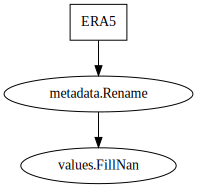

In [7]:
pipe = edit.pipeline.Pipeline(
    example_index,
    edit.pipeline.operations.xarray.metadata.Rename({'2t':'2_metre_temperature'}),
    edit.pipeline.operations.xarray.values.FillNan(),
)
pipe

Now we can see that we have added two more steps to the pipeline, and a nice graph shows up.

Just like before, we can index into this pipeline, and get the result of the steps

In [8]:
pipe['2000-01-01T00']

<xarray.Dataset> Size: 8MB
Dimensions:              (time: 1, latitude: 721, longitude: 1440)
Coordinates:
  * longitude            (longitude) float32 6kB -180.0 -179.8 ... 179.5 179.8
  * latitude             (latitude) float32 3kB 90.0 89.75 89.5 ... -89.75 -90.0
  * time                 (time) datetime64[ns] 8B 2000-01-01
Data variables:
    2_metre_temperature  (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 182, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-30 21:47:55 UTC+1000 by era5_replication_tools-1.2....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis 2m_temperature 20000101-20000131

Now lets convert to dask, and apply some operations over in dask land,

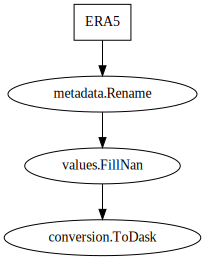

In [21]:
pipe = edit.pipeline.Pipeline(
    example_index,
    edit.pipeline.operations.xarray.metadata.Rename({'2t':'2_metre_temperature'}),
    edit.pipeline.operations.xarray.values.FillNan(),
    edit.pipeline.operations.xarray.conversion.ToDask(),
)
pipe

In [22]:
pipe['2000-01-01T00']

dask.array<stack, shape=(1, 1, 721, 1440), dtype=float64, chunksize=(1, 1, 182, 360), chunktype=numpy.ndarray>

As `edit` was developed in Australia, lets flip the world so things are the right way up

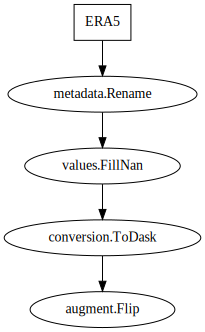

In [23]:
pipe += edit.pipeline.operations.dask.augment.Flip()
pipe

In [24]:
pipe['2000-01-01T00']

dask.array<stack, shape=(1, 1, 721, 1440), dtype=float64, chunksize=(1, 1, 182, 360), chunktype=numpy.ndarray>

Hopefully, you can see how we have added more steps to a pipeline to incremently modify the data. 

Defined in a pipeline, the operations can be quite easily viewed and understood, even saved out to disk as a loadable config

We can even `undo` all these operations and return the data to its original form

In [25]:
pipe.undo(pipe['2000-01-01T00'])

<xarray.Dataset> Size: 8MB
Dimensions:    (time: 1, latitude: 721, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 8B 2000-01-01
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
Data variables:
    2t         (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 182, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-30 21:47:55 UTC+1000 by era5_replication_tools-1.2....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis 2m_temperature 20000101-20000131